## Pedestrian space

In [1]:
import pandas as pd
import geopandas as gpd
import shapely as shp
import matplotlib.pyplot as plt
import osmnx as ox
import seaborn as sns
import numpy as np
from matplotlib.patches import Patch
from pyproj import Proj, Transformer

In [2]:
# Define paths
ITF_geospatial = r'./data_geospatial/ITF/'
APUR_geospatial = r'./data_geospatial/APUR/'
RESULTS = r'./results/'
ox_geocode = 'Paris, France' 

## Load
APUR provided two datasets:
- ```filaire_voie_paris.gdb``` contains road axis data with trottoir width per road side mapped to it. The dataset combines trottoir width with other available road information. One category for calculation method is not documented and thus unkown.
- ```Trottoir.gdb```contains measured sidewalk elements that are not mapped to road axis a single value for trottoir width. All categories of calculation method are documented.

In [3]:
troncon = gpd.read_file(APUR_geospatial+'filaire_voie_paris.gdb')

In [4]:
troncon.columns # attributes

Index(['n_sq_tv', 'c_niveau', 'c_domofftv', 'b_voiedup', 'n_voieaddg',
       'c_suf1addg', 'n_voieadfg', 'c_suf1adfg', 'n_voieaddd', 'c_suf1addd',
       'n_voieadfd', 'c_suf1adfd', 'c_coinsee', 'n_sq_co', 'n_sq_vo',
       'niv_sollicitation', 'largeur_minimum_t1', 'largeur_maximum_t1',
       'largeur_moyenne_t1', 'methode_calcul_t1', 'largeur_minimum_t2',
       'largeur_maximum_t2', 'largeur_moyenne_t2', 'methode_calcul_t2',
       'periode_construction', 'st_length_shape', 'shape_Length', 'geometry'],
      dtype='object')

In [5]:
len(troncon) # number of entries

25013

In [27]:
trottoir = gpd.read_file(APUR_geospatial+'TROTTOIR/Trottoir.shp')

In [28]:
trottoir.columns 

Index(['objectid', 'largeur', 'methode_ca', 'st_length_', 'geometry'], dtype='object')

In [29]:
len(trottoir)

1271613

In [31]:
trottoir.largeur.mean()

12.432017673402012

In [43]:
trottoir.methode_ca.value_counts()
reliable = trottoir.loc[trottoir.methode_ca == 1].copy()

(642349.6692550008, 661962.4810450028, 6857056.387865001, 6867551.321434999)

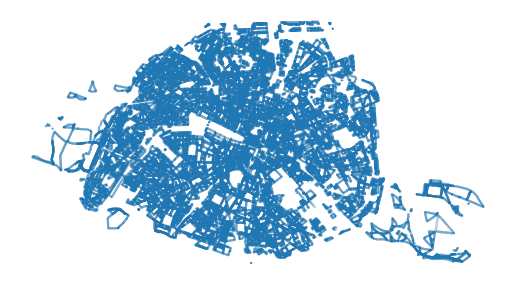

In [44]:
reliable.plot().axis('off')

In [51]:
def total_surface(df):
    df['surface'] = df.largeur * df.st_length_
    summed = df['surface'].sum() * 0.0001 # From m2 to ha
    print(f'{round(summed,0)} ha')
    return summed

def total_length(df):
    summed = df['st_length_'].sum() / 1000
    print(f'{round(summed,0)} km')
    return summed

In [52]:
total_surface(reliable)

1056.0 ha


1055.7314695302723

In [53]:
total_length(reliable)

1852.0 km


1851.6910995303078

In [37]:
trottoir['surface'] = trottoir.largeur * trottoir.st_length_

In [38]:
summed = trottoir['surface'].sum() * 0.0001 # From m2 to ha
summed

3612.487966094363

## Verify scale
Sampling a long, straight road to test whether length corresponds to measured distance of the same road on Google Maps, and to test whether trottoir width corresponds to sattelite image on Google Maps.

<Axes: xlabel='shape_Length', ylabel='Count'>

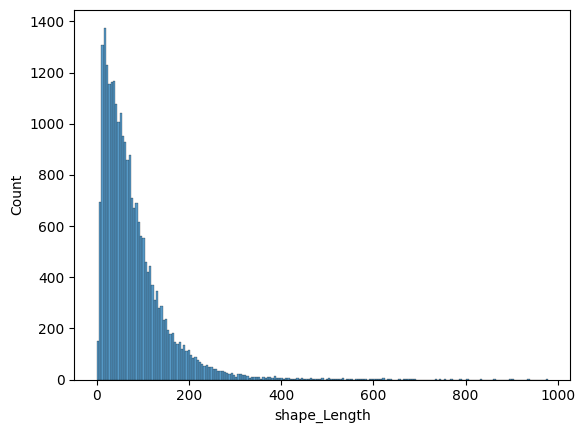

In [6]:
sns.histplot(troncon.shape_Length)

Extracting the longest road axis in the dataset to get the most accurate length measurement from Google Maps (if straight)

(642326.6603149961, 661972.4113850031, 6857005.439584999, 6867554.640115001)

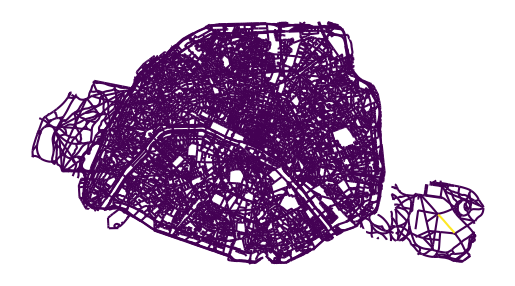

In [7]:
i_verif = troncon.shape_Length.idxmax()

troncon['mark'] = 0
troncon.at[i_verif, 'mark'] = 1
troncon.plot(column='mark').axis('off')

Longest road is also straight, so suitable sample for verification

In [8]:
print(f'{troncon.iloc[i_verif].shape_Length:.0f} m')

978 m


**<font color='green'>Verified length:</font>** Length corresponds with measured distance on Google Maps

In [9]:
print(f'{troncon.iloc[17261].largeur_moyenne_t2:.0f} m')

11 m


**<font color='green'>Verified width:</font>** Average trottoir width appears realistic when compared to streetview.

## Assess data quality

According to the data descriptor, method 1 is trustworthy, methods 2 and 4 are moderately reliable.

In [10]:
troncon.methode_calcul_t2.value_counts()

methode_calcul_t2
5.0    13184
1.0     6759
2.0     2158
4.0     1930
3.0      962
Name: count, dtype: int64

In [11]:
troncon.methode_calcul_t1.value_counts()

methode_calcul_t1
1.0    11278
5.0    10060
2.0     2817
4.0      508
3.0      330
Name: count, dtype: int64

In [22]:
i_verif = troncon.loc[troncon.methode_calcul_t2 == 5.0].index
i_verif

Index([    1,     2,     4,     7,     9,    10,    11,    12,    14,    18,
       ...
       24985, 24987, 24988, 24991, 24996, 25000, 25005, 25008, 25010, 25011],
      dtype='int64', length=13184)

(642326.6603149961, 661972.4113850031, 6857005.439584999, 6867554.640115001)

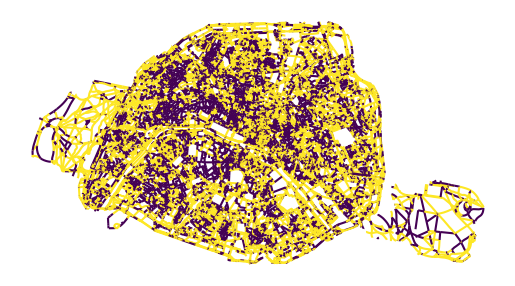

In [25]:
troncon['mark'] = 0
for i in i_verif:
    troncon.at[i, 'mark'] = 1
troncon.plot(column='mark').axis('off')

## Total trottoir surface

When using average, minimum, and maximum trottoir width

In [63]:
def surface_and_length(df, TYPE='moyenne', method=None):
    
    total_surface = 0

    if method:
        df1 = df.loc[troncon.methode_calcul_t1 == method].copy()
        df2 = df.loc[troncon.methode_calcul_t2 == method].copy()

        df1['t1_sq'] = df1[f"largeur_{TYPE}_t1"] * df1.shape_Length
        df2['t2_sq'] = df2[f"largeur_{TYPE}_t2"] * df2.shape_Length
        
        surface_sum1 = df1.t_sq_sum.sum() * 0.0001 # From m2 to ha
        length_sum1 = df1.shape_Length.sum() / 1000 # From m to km
        av_width1 = df1.t_sq_sum.sum() / df1.shape_Length.sum() #in m

        surface_sum2 = df2.t_sq_sum.sum() * 0.0001 # From m2 to ha
        length_sum2 = df2.shape_Length.sum() / 1000 # From m to km
        av_width2 = df2.t_sq_sum.sum() / df2.shape_Length.sum() #in m= 

        print(f'{TYPE}\n{surface_sum1:.0f} ha\n{length_sum1:.0f} km\n{av_width1:.0f} m\n')
        print(f'{surface_sum2:.0f} ha\n{length_sum2:.0f} km\n{av_width2:.0f} m')
        
    else:
        df['t1_sq'] = df[f"largeur_{TYPE}_t1"] * df.shape_Length
        df['t2_sq'] = df[f"largeur_{TYPE}_t2"] * df.shape_Length
    
        df['t_sq_sum'] = df[['t1_sq','t2_sq']].sum(axis=1)
        
        surface_sum = troncon.t_sq_sum.sum() * 0.0001 # From m2 to ha
        length_sum = troncon.shape_Length.sum() / 1000
    
        print(f'{TYPE}\n{surface_sum:.0f} ha\n{length_sum:.0f} km')



In [68]:
surface_and_length(troncon, 'moyenne', 1)

moyenne
981 ha
855 km
11 m

408 ha
504 km
8 m


In [13]:
for TYPE in ['minimum', 'moyenne', 'maximum']:
    total_surface = 0
    troncon['t1_sq'] = troncon[f"largeur_{TYPE}_t1"] * troncon.shape_Length
    troncon['t2_sq'] = troncon[f"largeur_{TYPE}_t2"] * troncon.shape_Length

    troncon['t_sq_sum'] = troncon[['t1_sq','t2_sq']].sum(axis=1)
    troncon['t_sq_max'] = troncon[['t1_sq','t2_sq']].max(axis=1) # some are measured based on
    
    surface_sum = troncon.t_sq_sum.sum() * 0.0001 # From m2 to ha
    surface_max = troncon.t_sq_max.sum() * 0.0001
    
    print(f'{TYPE}\n{surface_max:.0f}ha - {surface_sum:.0f}ha\n')

minimum
1109ha - 1516ha

moyenne
2617ha - 3559ha

maximum
4742ha - 7088ha



Taking average and maximum values leads to results above total road space surface of Paris and cannot be valid.
Taking the minimum value appears more plausible